In [368]:

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

El objetivo era desarrollar un sistema para detectar un logotipo específico en una imagen compleja, abordando el desafio de la variación de escala y las detecciones múltiples. El proceso fue iterativo, construyendo sobre los aprendizajes de cada etapa. Se contará un poco como se fue evolucionando y los limitaciones que se encontraron en cada enfoque.

### El Enfoque Inicial - Escalado Simple y Detección Única

Se comenzó con un enfoque exploratorio y directo. La primera versión del algoritmo intentaba resolver el problema de la escala desconocida del logo.

- Técnica: Se implementó un bucle que redimensionaba la plantilla a varias escalas (`np.linspace`). Para cada escala, se utilizaba `cv.matchTemplate` para buscar coincidencias.

- Limitación Clave: En esta fase inicial, solo se identificaba la mejor y única coincidencia (`cv.minMaxLoc`) para cada escala. Esto impedía detectar múltiples logos y no filtraba eficazmente las coincidencias de baja calidad, resultando en una solución incompleta.


### Múltiples Detecciones y el Problema de la Redundancia

El siguiente paso fue superar la limitación de una sola detección.

- Avance: Se introdujo el concepto de un umbral de confianza. En lugar de buscar solo el punto de máxima coincidencia, se utilizó np.where para encontrar todas las ubicaciones cuyo puntaje de correlación superaba este umbral.
- Nuevo Problema: Este enfoque, aunque más completo, generó un nuevo desafío: una abundancia de detecciones redundantes. Para cada logo real, el sistema ahora identificaba docenas de cajas delimitadoras muy superpuestas, provenientes de escalas y posiciones ligeramente diferentes. La salida era ruidosa y difícil de interpretar.

### La Profundización en IoU y la Supresión de No Máximos (NMS)

Para resolver el problema de la redundancia, utliamos técnicas estándar de la industria para el post-procesamiento de detecciones.

- Solución Propuesta: Se introdujo el concepto de Intersección sobre Unión (IoU) como la métrica estándar para cuantificar el grado de superposición entre dos cajas.

- Algoritmo Clave: Utilizamos IoU como el motor de la Supresión de No Máximos (NMS), el algoritmo diseñado para analizar un grupo de cajas superpuestas, quedarse con la de mayor confianza y eliminar las demás.

- "ida y vuelta" con IoU:
    - Primero, integramos la función nativa y optimizada de OpenCV, cv.dnn.NMSBoxes, que es la solución más eficiente.
    - Para un entendimiento más profundo, se construyyo desde cero una función calcular_iou manual en Python. Esto dio un poco mas de control sobre la metrica.
    - Adaptando la función a diferentes formatos de cajas ((x1,y1,x2,y2) vs. (x,y,w,h)) para mejorar la legibilidad y eficiencia del código principal.


### Una Estrategia Alternativa - Filtrado por Densidad

En un ejercicio de pensamiento creativo, se exploró una lógica alternativa al NMS.

- Idea Clave: En lugar de suprimir cajas, la idea fue seleccionar solo aquellas que pertenecían a "cúmulos" de alta densidad. Creamos un mapa que contaba, para cada caja, con cuántas otras se intersectaba significativamente.
- Resultado: Este método se identificó como una excelente técnica de análisis para encontrar las "zonas más prometedoras" de la imagen.

### La Síntesis Final

El algoritmo evolucionó a un pipeline de dos etapas:

- Etapa de Calibración: Un primer paso inteligente para analizar la imagen y determinar la escala y el método de coincidencia óptimos que producían el `max_score` global.

- Etapa de Detección y Limpieza: Usar la plantilla ya calibrada para realizar una única y eficiente pasada de `cv.matchTemplate`. Se aplicó un umbral de confianza dinámico (relativo al `max_score`) para encontrar todos los candidatos prometedores, y finalmente se utilizó NMS (cv.dnn.NMSBoxes) para obtener un resultado final limpio, preciso y sin redundancias.

### Refiniamiento Final

Búsqueda por Relación de Aspecto: Como último paso para maximizar la robustez, el algoritmo fue mejorado para manejar deformaciones del logo debidas a la perspectiva. La fase de calibración se extendió para no solo buscar la mejor escala, sino también la mejor relación de aspecto. Se introdujo un nuevo bucle que prueba varias deformaciones del template (ej. versiones más delgadas o más anchas), permitiendo que el detector encuentre coincidencias incluso cuando el logo está en una superficie curva o visto desde un ángulo. Esta adición, aunque computacionalmente más intensiva, dota al sistema de una capacidad significativamente mayor para adaptarse a las condiciones del mundo real.





In [369]:
def find(target_file, template_file, 
         # Parámetros de escala
         scale_range=(0.2, 1.0), scale_steps=20,
         aspect_ratios_range=(0.9, 1.1), aspect_ratios_steps=3,
         # Parámetros de Canny
         canny_thresh1=100, canny_thresh2=200,
         # Parámetros de confianza y NMS
         rel_confidence_factor=0.8, iou_thresh=0.3,
         # Parámetro de control
         verbose=True):
    """
    Detecta una plantilla en una imagen objetivo usando un pipeline de dos fases.
    1. Calibración: Encuentra la mejor escala y método.
    2. Detección: Usa los mejores parámetros para encontrar todas las ocurrencias.
    """
    
    target = cv.imread(target_file)
    target_gray = cv.cvtColor(target, cv.COLOR_BGR2GRAY)
    template = cv.imread(template_file, 0) 
    target_edges = cv.Canny(target_gray, threshold1=canny_thresh1, threshold2=canny_thresh2)
  
    def resize_template(template, scale, aspect_ratio, target_shape):
        base_h, base_w = template.shape[:2]
        
        height = int((base_h * scale) / np.sqrt(aspect_ratio))
        width = int((base_w * scale) * np.sqrt(aspect_ratio))
        
        # Chequeamos que los valores del template tengan sentido
        if width <= 0 or height <= 0 or width > target_shape[1] or height > target_shape[0]: 
            return None
        
        resized = cv.resize(template, (width, height), interpolation=cv.INTER_AREA)
        edges = cv.Canny(resized, canny_thresh1, canny_thresh2)
        
        return (edges, width, height)

    def find_best_score(target, template, method):
        res = cv.matchTemplate(target, template, method)
        min_val, max_val, _, _ = cv.minMaxLoc(res)
        # Re-Normalizamos para SQDIFF
        if method in [cv.TM_SQDIFF_NORMED]: 
            return 1 - min_val
        else: 
            return max_val


    ###
    # Fase de Calibración
    ###
    scores = []
    methods_to_test = [cv.TM_CCOEFF_NORMED, cv.TM_CCORR_NORMED, cv.TM_SQDIFF_NORMED]
    
    if verbose: 
        print("Buscando la mejor combinación de escala y método...")
    
    for method in methods_to_test:
        for scale in np.linspace(scale_range[0], scale_range[1], scale_steps):
            for ar in np.linspace(aspect_ratios_range[0], aspect_ratios_range[1], aspect_ratios_steps):
                resize_result = resize_template(template, scale, ar, target_edges.shape)
                if resize_result is None: continue
                resized_template_edges, _, _ = resize_result
                score = find_best_score(target_edges, resized_template_edges, method)
                scores.append((score, scale, ar, method))

    scores_matrix = np.array(scores)
    sorted_indices = np.argsort(scores_matrix[:, 0])[::-1]
    sorted_scores = scores_matrix[sorted_indices]
    max_score, best_scale, best_ar, best_method = sorted_scores[0]
    best_method = int(best_method)

    if verbose:
        print(f"\nMejor resultado encontrado:")
        print(f"  - Score: {max_score:.4f}, Escala: {best_scale:.2f}, Método: {best_method}, Aspect ratio: {best_ar}")

    ###
    # Fase de Detección
    ###
    resize_result = resize_template(template, best_scale, best_ar, target_edges.shape)

    if resize_result is None:
        raise ValueError('No se pudo generar el template.')
    
    best_template_edges, w, h = resize_result
    res = cv.matchTemplate(target_edges, best_template_edges, best_method)
    
    final_threshold = rel_confidence_factor * max_score
    loc = np.where(res >= final_threshold)

    boxes_candidatas = []
    scores_candidatos = []
    
    for pt in zip(*loc[::-1]):
        boxes_candidatas.append([pt[0], pt[1], w, h])
        scores_candidatos.append(res[pt[1], pt[0]])

    if verbose: print(f"\nSe encontraron {len(boxes_candidatas)} cajas candidatas (confianza > {final_threshold:.2f}).")
    ###
    # Fase de Limpieza (NMS) 
    ###
    indices = cv.dnn.NMSBoxes(boxes_candidatas, scores_candidatos, final_threshold, iou_thresh)
    
    # Visualización
    img_salida = target.copy() # Usamos el target original BGR
    if len(indices) > 0:
        for i in indices.flatten():
            (x, y, w_box, h_box) = boxes_candidatas[i]
            pt1 = (x, y); pt2 = (x + w_box, y + h_box)
            cv.rectangle(img_salida, pt1, pt2, (0, 255, 0), 2)
            score_final = scores_candidatos[i]
            texto = f"{score_final:.2f}"
            cv.putText(img_salida, texto, (x, y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

    if verbose: print(f"Después de NMS con IoU, quedaron {len(indices)} cajas finales.")

    if verbose:
        plt.figure(figsize=(10, 8))
        plt.imshow(cv.cvtColor(img_salida, cv.COLOR_BGR2RGB))
        plt.title('Detecciones Finales')
        plt.xticks([]), plt.yticks([])
        plt.show()

    # Devolvemos la caja encontrada y el score asociado.
    final_boxes = []
    for i in indices.flatten():
        final_boxes.append((boxes_candidatas[i], scores_candidatos[i]))

    return final_boxes


Buscando la mejor combinación de escala y método...

Mejor resultado encontrado:
  - Score: 0.4732, Escala: 0.24, Método: 3, Aspect ratio: 0.9

Se encontraron 26 cajas candidatas (confianza > 0.38).
Después de NMS con IoU, quedaron 14 cajas finales.


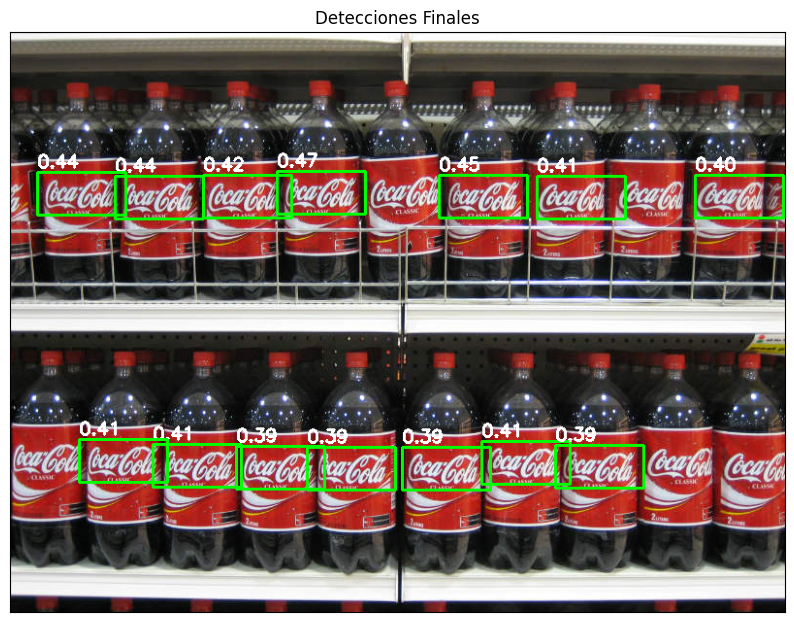

[([np.int64(275), np.int64(144), 91, 44], np.float32(0.4731785)),
 ([np.int64(442), np.int64(148), 91, 44], np.float32(0.45347586)),
 ([np.int64(108), np.int64(149), 91, 44], np.float32(0.43984714)),
 ([np.int64(28), np.int64(145), 91, 44], np.float32(0.43869796)),
 ([np.int64(199), np.int64(148), 91, 44], np.float32(0.4207842)),
 ([np.int64(147), np.int64(425), 91, 44], np.float32(0.4110667)),
 ([np.int64(71), np.int64(420), 91, 44], np.float32(0.40908965)),
 ([np.int64(543), np.int64(149), 91, 44], np.float32(0.40789175)),
 ([np.int64(486), np.int64(422), 91, 44], np.float32(0.4063664)),
 ([np.int64(706), np.int64(148), 91, 44], np.float32(0.40300658)),
 ([np.int64(562), np.int64(426), 91, 44], np.float32(0.39200798)),
 ([np.int64(306), np.int64(428), 91, 44], np.float32(0.38969105)),
 ([np.int64(233), np.int64(427), 91, 44], np.float32(0.3891881)),
 ([np.int64(404), np.int64(428), 91, 44], np.float32(0.38533944))]

In [370]:
# Probando con una imagen con multiple detecciones
find('./images/coca_multi.png', './template/pattern.png')


Buscando la mejor combinación de escala y método...

Mejor resultado encontrado:
  - Score: 0.3593, Escala: 0.41, Método: 3, Aspect ratio: 0.9

Se encontraron 12 cajas candidatas (confianza > 0.29).
Después de NMS con IoU, quedaron 1 cajas finales.


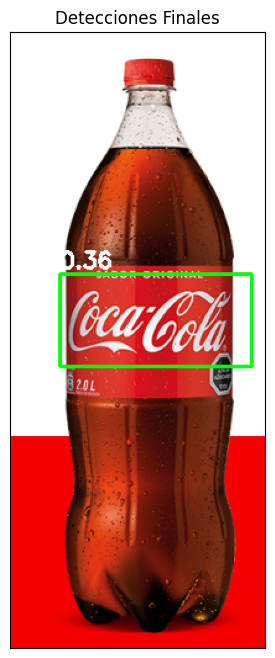

Buscando la mejor combinación de escala y método...

Mejor resultado encontrado:
  - Score: 0.4009, Escala: 0.37, Método: 3, Aspect ratio: 1.1

Se encontraron 11 cajas candidatas (confianza > 0.32).
Después de NMS con IoU, quedaron 1 cajas finales.


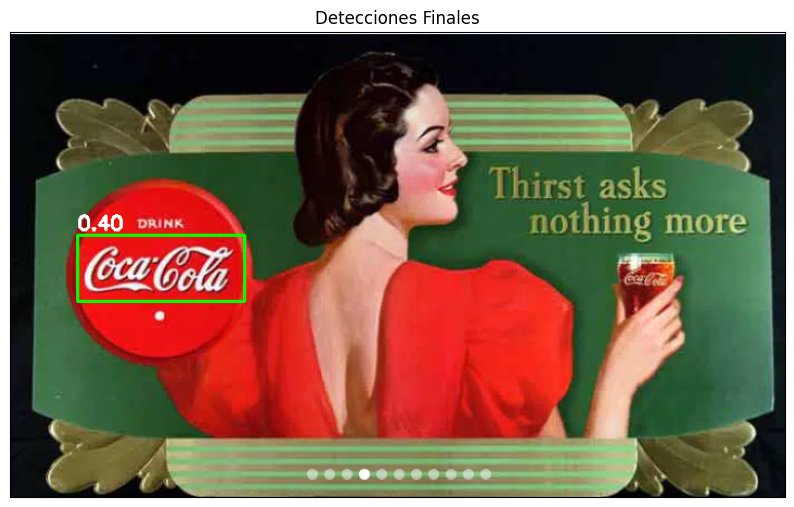

[([np.int64(62), np.int64(187), 154, 61], np.float32(0.40088266))]

In [371]:
# Probando con una sola imagen
find('./images/coca_logo_1.png', './template/pattern.png')
find('./images/coca_retro_2.png', './template/pattern.png')


Buscando la mejor combinación de escala y método...

Mejor resultado encontrado:
  - Score: 0.2325, Escala: 0.80, Método: 3, Aspect ratio: 0.9

Se encontraron 17 cajas candidatas (confianza > 0.19).
Después de NMS con IoU, quedaron 1 cajas finales.


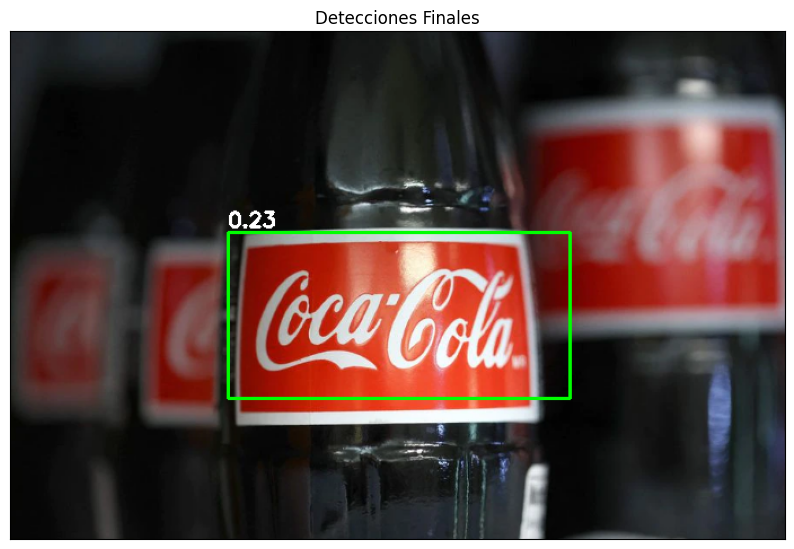

[([np.int64(193), np.int64(178), 303, 147], np.float32(0.23253433))]

In [372]:
# Cambiando el rango de la escala podemos obtener una aproximacion para esta imagen
find('./images/logo_1.png', './template/pattern.png', scale_range=(0.8, 1.0))


Buscando la mejor combinación de escala y método...

Mejor resultado encontrado:
  - Score: 0.0937, Escala: 3.32, Método: 3, Aspect ratio: 0.9

Se encontraron 287 cajas candidatas (confianza > 0.07).
Después de NMS con IoU, quedaron 1 cajas finales.


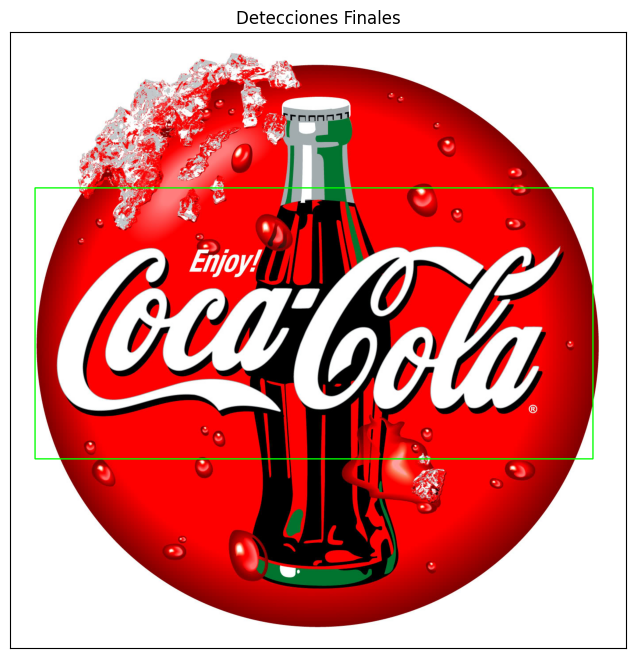

[([np.int64(56), np.int64(351), 1258, 611], np.float32(0.09373665))]

In [373]:
# En este caso el logo es bastante mas grande que el template por eso se utiliza la escala en cuestion, el score es muy bajo
find('./images/COCA-COLA-LOGO.jpg', './template/pattern.png', scale_range=(3.0, 4.0), scale_steps=20)


Buscando la mejor combinación de escala y método...

Mejor resultado encontrado:
  - Score: 0.2040, Escala: 0.60, Método: 3, Aspect ratio: 0.9

Se encontraron 84 cajas candidatas (confianza > 0.16).
Después de NMS con IoU, quedaron 1 cajas finales.


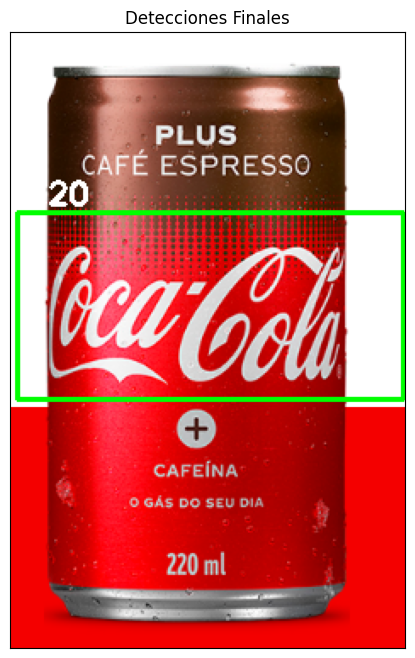

[([np.int64(4), np.int64(106), 227, 110], np.float32(0.20399976))]

In [374]:
# En esta imagen el logo esta un poco mas comprimido alo ancho de lo habitual.
find('./images/coca_logo_2.png', './template/pattern.png', scale_range=(0.6, 1.0))


Buscando la mejor combinación de escala y método...

Mejor resultado encontrado:
  - Score: 0.1712, Escala: 1.00, Método: 3, Aspect ratio: 2.75

Se encontraron 1371 cajas candidatas (confianza > 0.14).
Después de NMS con IoU, quedaron 1 cajas finales.


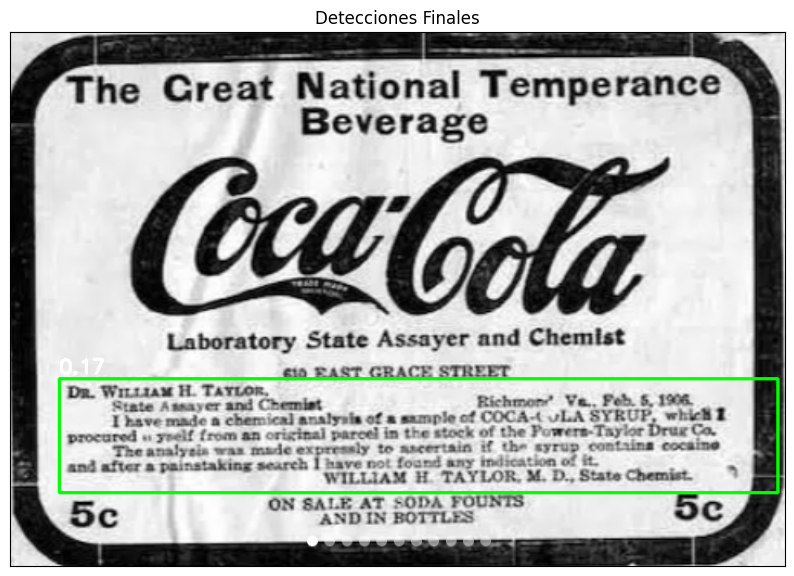

[([np.int64(45), np.int64(320), 663, 105], np.float32(0.17117931))]

In [375]:
find('./images/coca_retro_1.png', './template/pattern.png', 
     scale_range=(1, 1.5), 
     scale_steps=20,
     aspect_ratios_range=(2.5, 3), 
     aspect_ratios_steps=5)
